In [1]:
import sys
sys.path.append("D:/Notebooks/modules")
from utils import scantree
from utils_3d import show_slices_gif_tensor, show_slices_gif_paths, rotate_3d_tensor, plot_3d_volume_mayavi, TensorPathsDataset
from transforms import Rotate3d
from CTKidney_models import VCNNI

import random
import torch
from torch import nn
import torchsummary
import os
from collections import defaultdict
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


d:\ProgramFiles\anaconda3\envs\pytorch_env\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
d:\ProgramFiles\anaconda3\envs\pytorch_env\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [2]:
config = {
    'input_shape': (30, 128, 128),
    'batch_size': 64,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'n_epochs': 200,
    'seed': 0
}

In [3]:
train_dataset = TensorPathsDataset(r'D:\Notebooks\Kidney CT\augmented_volumes\Rotate3d_AllAxes_-30to30_RandomFlip3d\Train', 20, 'train')
valid_dataset = TensorPathsDataset(r'D:\Notebooks\Kidney CT\augmented_volumes\Rotate3d_AllAxes_-30to30_RandomFlip3d\Valid', 20, 'valid')

print(len(train_dataset), len(valid_dataset))

train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle= True)
valid_loader = DataLoader(valid_dataset, batch_size = config['batch_size'])

152 21


In [4]:
volumes, labels = next(iter(valid_loader))
print(volumes.shape, labels.shape)
print(volumes.min(), volumes.max(), labels)

torch.Size([21, 20, 30, 128, 128]) torch.Size([21])
tensor(0.) tensor(1.) tensor([0, 3, 3, 0, 0, 2, 0, 2, 1, 1, 0, 3, 1, 1, 2, 0, 0, 1, 3, 1, 3])


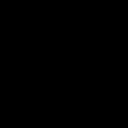

In [5]:
show_slices_gif_tensor(volumes[0][0])
# plot_3d_volume_mayavi(volumes[0][0])

In [6]:
model = VCNNI(input_shape= config['input_shape']).to(config['device'])
torchsummary.summary(model, input_size=config['input_shape'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]          17,344
              ReLU-2         [-1, 64, 126, 126]               0
         MaxPool2d-3           [-1, 64, 63, 63]               0
            Conv2d-4           [-1, 64, 61, 61]          36,928
              ReLU-5           [-1, 64, 61, 61]               0
            Conv2d-6           [-1, 64, 59, 59]          36,928
              ReLU-7           [-1, 64, 59, 59]               0
         MaxPool2d-8           [-1, 64, 29, 29]               0
           Dropout-9           [-1, 64, 29, 29]               0
          Flatten-10                [-1, 53824]               0
           Linear-11                 [-1, 2048]     110,233,600
             ReLU-12                 [-1, 2048]               0
           Linear-13                    [-1, 4]           8,196
Total params: 110,332,996
Trainable par

In [7]:
out = model.forward_multi_view(torch.rand(20, 30, 128, 128, device = 'cuda'))
out.shape

torch.Size([1, 4])

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay= 0.001, momentum= 0.9)
loss_fn = nn.CrossEntropyLoss()

def get_accuracy(logits, targets):
    preds = torch.argmax(logits, dim = 1)
    return torch.sum(preds == targets).item() / len(preds)

In [9]:
batch, labels = next(iter(valid_loader))
batch.shape, labels.shape

(torch.Size([21, 20, 30, 128, 128]), torch.Size([21]))

In [10]:
train_losses = []
valid_losses = []

best_acc = 0
best_loss = 100

for epoch in range(config['n_epochs']):
    train_loss = 0
    valid_loss = 0
    
    train_acc = 0
    valid_acc = 0
    
    model.train()
    
    for volumes, labels in train_loader:
        volumes, labels = volumes.to(config['device']), labels.to(config['device'])
        
        logits = model(volumes)
        loss = loss_fn(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().cpu().item()
        train_acc += get_accuracy(logits, labels)
        
    model.eval()
    
    with torch.inference_mode():
        for batch, labels in valid_loader:
            batch, labels = batch.to(config['device']), labels.to(config['device'])
            logits_list = []

            for volumes in batch:
                logits = model.forward_multi_view(volumes)
                logits_list.append(logits.squeeze())

            logits_list = torch.stack(logits_list)
            loss = loss_fn(logits_list, labels)
            valid_loss += loss.detach().cpu().item()
            valid_acc += get_accuracy(logits_list, labels)

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    train_acc /= len(train_loader)
    valid_acc /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if epoch % 1 == 0:
        print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Acc: {valid_acc:.4f}")

    # Save the model with highest accuracy
    if epoch > 10 and ((valid_acc > best_acc) or (valid_acc == best_acc and valid_loss < best_loss)):
        best_acc, best_loss = valid_acc, valid_loss
        torch.save(model.state_dict(), "V-CNN I.pt")
        print("Checkpoint was saved!")

print(f"Best validation accuracy: {best_acc:.4f}")

Epoch: 1 | Train Loss: 1.3876 | Valid Loss: 1.3871 | Train Acc: 0.1146 | Valid Acc: 0.1429
Epoch: 2 | Train Loss: 1.3864 | Valid Loss: 1.3869 | Train Acc: 0.2691 | Valid Acc: 0.3333
Epoch: 3 | Train Loss: 1.3846 | Valid Loss: 1.3865 | Train Acc: 0.3698 | Valid Acc: 0.3333
Epoch: 4 | Train Loss: 1.3825 | Valid Loss: 1.3862 | Train Acc: 0.3663 | Valid Acc: 0.3333
Epoch: 5 | Train Loss: 1.3799 | Valid Loss: 1.3858 | Train Acc: 0.3663 | Valid Acc: 0.3333
Epoch: 6 | Train Loss: 1.3736 | Valid Loss: 1.3855 | Train Acc: 0.4097 | Valid Acc: 0.3333
Epoch: 7 | Train Loss: 1.3737 | Valid Loss: 1.3853 | Train Acc: 0.3576 | Valid Acc: 0.3333
Epoch: 8 | Train Loss: 1.3709 | Valid Loss: 1.3853 | Train Acc: 0.3663 | Valid Acc: 0.3333
Epoch: 9 | Train Loss: 1.3682 | Valid Loss: 1.3852 | Train Acc: 0.3750 | Valid Acc: 0.3333
Epoch: 10 | Train Loss: 1.3654 | Valid Loss: 1.3851 | Train Acc: 0.3576 | Valid Acc: 0.3333
Epoch: 11 | Train Loss: 1.3577 | Valid Loss: 1.3851 | Train Acc: 0.4010 | Valid Acc: 0.33

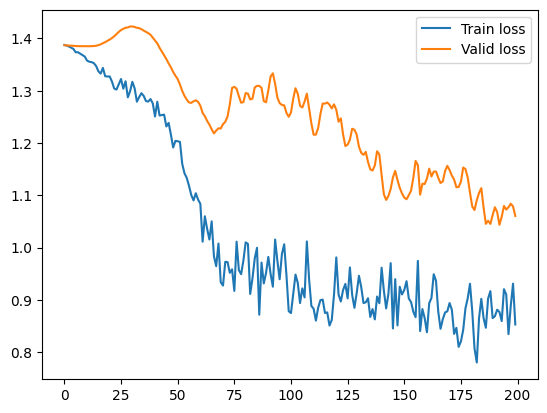

In [11]:
plt.plot(range(len(train_losses)), train_losses, label = 'Train loss')
plt.plot(range(len(valid_losses)), valid_losses, label = 'Valid loss')
plt.legend()